# Marker gene database maker
The purpose of this jupyter notebook is to run through a workflow of creating a blast database containing protein sequences of a given gene from a wide range of taxonomic groups that can be used to validate newly submitted sequences against. 

Broadly, this process involves the following steps: 

1. Starting with an Entrez query for the Gene database, download sequences and metadata for genes, transcripts and proteins using esearch/efetch
2. Parse the data archive from step 1 to tabulate names and symbols for review
3. Parse the data archive from step 1 to tabulate variability in the sequence lengths for review 
4. Given a set of taxonomic group identifiers, tabulate the number of sequences for each group that are present in the data archive
5. Generate all-vs-all BLAST alignments 
6. Review the BLAST tabular output to make a list of accessions that are outliers or incorrect that need to be removed from the final BLAST database 
7. Generate a final BLAST database that can be used with VADR and other tools for validating newly submitted sequences.

In [1]:
import Bio
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
import sys
import seaborn as sns
#import numpy as np
#from ete3 import NCBITaxa
#ncbi = NCBITaxa()
#ncbi.update_taxonomy_database()
import subprocess

# Specify variables for Entrez query and download data

Sequence and metadata are downloaded using esearch and efetch using an Entrez query variables provided by the user. The full entrez query is encoded in script gene_uid_query.sh

"esearch -db gene -query "organism [ORGN] AND genename [GENE] mitochon AND alive [PROP] AND gene protein refseq [FILT] NOT rnatype mrna [PROP] NOT srcdb pdb [PROP] NOT uncultured NOT unverified" | efetch -format uid | sort -n | uniq"

Variables are:
1. gene (Name of gene (e.g., cytb))
2. organism (Limit query by taxonomic group (e.g., mammalia))
3. mitochondria (Restrict query to mitochondrial genes)

In [2]:
!gene_uid_query.sh -organism metazoa -gene cytb -mito | obtain_gene_datasets.sh
gene_ids_file = 'gene_ids.txt'

Mismatched columns in row 1062 - '158508410	MT	pale sea urchin	cytochrome b	5692589	CYTB	7670	Strongylocentrotus pallidus	NC_009941.1	14571	15712	NC_009941.1	1	1	YP_001527864.1	380	cytochrome b'
Mismatched columns in row 1063 - '158508424	MT	green sea urchin	cytochrome b	5692627	CYTB	7671	Strongylocentrotus droebachiensis	NC_009940.1	14576	15717	NC_009940.1	1	1	YP_001527851.1	380	cytochrome b'
Elapsed time 1162 seconds


## Tabulate unique names

In [2]:
data_table = 'data_table.tsv'
gene_names = 'gene_names.tsv'

In [3]:
%%bash -s {data_table} {gene_names}

data_table=$1
gene_names=$2

python3 scripts/unique.py ${data_table} > ${gene_names}

In [3]:
df = pd.read_csv(gene_names, sep='\t', header=None, names=['Gene Name', 'Count', 'Gene IDs'])
display(df.sort_values(by=['Count'], ascending=False))

,Gene Name,Count,Gene IDs
0,10002870,1,CYTB
6908,41659585,1,CYTB
6850,4107965,1,CYTB
6851,4108059,1,CYTB
6852,4108073,1,CYTB
...,...,...,...
3429,2658451,1,CYTB
3430,2658463,1,CYTB
3431,2658512,1,CYTB
3432,2658552,1,CYTB


## Summarize data table and calculate tax stats

In [4]:
pd.set_option('display.max_rows', 500)
data_table_df = pd.read_csv(data_table, sep='\t', index_col=1)
data_table_df.rename(columns={"scientific_name": "taxname", "tax_id": "#taxid"}, inplace=True)
data_table_df.head(500)

,gene_symbol,taxname,#taxid,genomic_range,orientation,location,protein_accession,protein_length,protein_name
gene_id,,,,,,,,,
4519,CYTB,Homo sapiens,9606,NC_012920.1:14747-15887,+,chr MT,YP_003024038.1,380.0,cytochrome b
17711,CYTB,Mus musculus,10090,NC_005089.1:14145-15288,+,chr MT,NP_904340.1,381.0,cytochrome b
26192,CYTB,Rattus norvegicus,10116,NC_001665.2:14136-15278,+,chr MT,YP_665641.1,380.0,cytochrome b
140512,CYTB,Danio rerio,7955,NC_002333.2:15308-16448,+,chr MT,NP_059343.1,380.0,cytochrome b
800003,CYTB,Schistosoma mekongi,38744,NC_002529.1:2654-3772,+,chr MT,NP_065423.2,372.0,cytochrome b
800017,CYTB,Schistosoma mansoni,6183,NC_002545.1:10260-11354,+,chr MT,NP_066212.2,364.0,cytochrome b
800033,CYTB,Fasciola hepatica,6192,NC_002546.1:715-1827,+,chr MT,NP_066218.2,370.0,cytochrome b
800040,CYTB,Taenia crassiceps,6207,NC_002547.1:787-1860,+,chr MT,NP_066230.2,357.0,cytochrome b
800062,CYTB,Schistosoma japonicum,6182,NC_002544.1:2596-3711,+,chr MT,NP_066196.2,371.0,cytochrome b


In [5]:
data_table_df.to_csv('taxid_list', index=False, header=False, sep ='\t', columns=['#taxid'])
os.system("/panfs/pan1.be-md.ncbi.nlm.nih.gov/protein_clusters/BIN/nodesByStaxID -in taxid_list -ranks phylum,class,order,family,genus,species > lineage")
tax_report = (r'lineage')
lineage_df = pd.read_csv(tax_report, sep='\t', index_col=None, na_values=['-'])
lineage_df

,#taxid,taxname,phylum,class,order,family,genus,species
0,9606,Homo sapiens,Chordata,Mammalia,Primates,Hominidae,Homo,NaN
1,10090,Mus musculus,Chordata,Mammalia,Rodentia,Muridae,Mus,NaN
2,10116,Rattus norvegicus,Chordata,Mammalia,Rodentia,Muridae,Rattus,NaN
3,7955,Danio rerio,Chordata,Actinopteri,Cypriniformes,Danionidae,Danio,NaN
4,38744,Schistosoma mekongi,Platyhelminthes,Trematoda,Strigeidida,Schistosomatidae,Schistosoma,NaN
...,...,...,...,...,...,...,...,...
10277,54323,Percina copelandi,Chordata,Actinopteri,Perciformes,Percidae,Percina,NaN
10278,322563,Proterorhinus semilunaris,Chordata,Actinopteri,Gobiiformes,Gobiidae,Proterorhinus,NaN
10279,2793285,Ophichthys cuchia,Chordata,Actinopteri,Synbranchiformes,Synbranchidae,Ophichthys,NaN
10280,244777,Carpiodes cyprinus,Chordata,Actinopteri,Cypriniformes,Catostomidae,Carpiodes,NaN


In [6]:
lineage2_df = lineage_df.drop(columns=['taxname'])
table_combined = pd.merge(left=data_table_df, right=lineage2_df, left_on='#taxid', right_on='#taxid')
table_combined.drop_duplicates(subset=['protein_accession'], inplace=True)
table_combined.drop(columns=['orientation', 'location', 'gene_symbol', 'protein_name'], inplace=True)
table_combined.to_csv(r'table_combined', sep ='\t', index = True) 
table_combined
#if table_combined['class'].isnull().values.any():
    #print("found nan")
    

,taxname,#taxid,genomic_range,protein_accession,protein_length,phylum,class,order,family,genus,species
0,Homo sapiens,9606,NC_012920.1:14747-15887,YP_003024038.1,380.0,Chordata,Mammalia,Primates,Hominidae,Homo,NaN
1,Mus musculus,10090,NC_005089.1:14145-15288,NP_904340.1,381.0,Chordata,Mammalia,Rodentia,Muridae,Mus,NaN
2,Rattus norvegicus,10116,NC_001665.2:14136-15278,YP_665641.1,380.0,Chordata,Mammalia,Rodentia,Muridae,Rattus,NaN
3,Danio rerio,7955,NC_002333.2:15308-16448,NP_059343.1,380.0,Chordata,Actinopteri,Cypriniformes,Danionidae,Danio,NaN
4,Schistosoma mekongi,38744,NC_002529.1:2654-3772,NP_065423.2,372.0,Platyhelminthes,Trematoda,Strigeidida,Schistosomatidae,Schistosoma,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10291,Percina copelandi,54323,NC_056401.1:14380-15520,YP_010133046.1,380.0,Chordata,Actinopteri,Perciformes,Percidae,Percina,NaN
10292,Proterorhinus semilunaris,322563,NC_056402.1:14427-15564,YP_010133059.1,379.0,Chordata,Actinopteri,Gobiiformes,Gobiidae,Proterorhinus,NaN
10293,Ophichthys cuchia,2793285,NC_056403.1:14331-15468,YP_010133072.1,379.0,Chordata,Actinopteri,Synbranchiformes,Synbranchidae,Ophichthys,NaN
10294,Carpiodes cyprinus,244777,NC_056404.1:14399-15539,YP_010133085.1,380.0,Chordata,Actinopteri,Cypriniformes,Catostomidae,Carpiodes,NaN


## Evaluate numbers of sequences in different taxonomic groupings

In [7]:
pd.set_option('display.max_rows', 500)
#lineage_df.groupby('class').count()
#count = table_combined.groupby('class').count()
count = table_combined.groupby('class').size()
count.to_csv('taxsummary', sep='\t')
table_combined.groupby('class').count().head(500)

,taxname,#taxid,genomic_range,protein_accession,protein_length,phylum,order,family,genus,species
class,,,,,,,,,,
Actinopteri,2771,2771,2771,2771,2771,2771,2651,2743,2733,36
Allomalorhagida,1,1,1,1,1,1,0,1,1,0
Amphibia,300,300,300,300,300,300,300,300,300,1
Anthozoa,165,165,165,165,165,165,165,165,164,0
Arachnida,173,173,173,173,173,173,173,171,173,0
Archiacanthocephala,2,2,2,2,2,2,2,2,2,0
Ascidiacea,25,25,25,25,25,25,25,25,25,1
Asteroidea,18,18,18,18,18,18,18,18,18,0
Aves,930,930,930,930,930,930,930,918,930,14


## Make smaller dataframes for further analysis by tax group

In [9]:
taxset_df = table_combined[table_combined['class'] == "Insecta"]
taxset_acc = taxset_df['protein_accession']
taxset_acc.to_csv('taxset_acclist', index = False, header = None)
taxset_df


,taxname,#taxid,genomic_range,protein_accession,protein_length,phylum,class,order,family,genus,species
10,Triatoma dimidiata,72491,NC_002609.1:10252-11383,NP_068653.1,377.0,Arthropoda,Insecta,Hemiptera,Reduviidae,Triatoma,NaN
22,Cochliomyia hominivorax,115425,NC_002660.1:11607-12743,NP_075459.1,378.0,Arthropoda,Insecta,Diptera,Calliphoridae,Cochliomyia,NaN
27,Chrysomya putoria,235600,NC_002697.1:10410-11546,NP_085093.1,378.0,Arthropoda,Insecta,Diptera,Calliphoridae,Chrysomya,NaN
61,Tribolium castaneum,7070,NC_003081.2:10280-11417,NP_203166.1,379.0,Arthropoda,Insecta,Coleoptera,Tenebrionidae,Tribolium,NaN
111,Crioceris duodecimpunctata,184539,NC_003372.1:10274-11410,NP_569071.1,378.0,Arthropoda,Insecta,Coleoptera,Chrysomelidae,Crioceris,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10240,Tropidothorax cruciger,1310363,NC_056293.1:4143-5276,YP_010128168.1,377.0,Arthropoda,Insecta,Hemiptera,Lygaeidae,Tropidothorax,NaN
10265,Metaphycus eriococci,2498640,NC_056349.1:10463-11605,YP_010131045.1,380.0,Arthropoda,Insecta,Hymenoptera,Encyrtidae,Metaphycus,NaN
10269,Pantala flavescens,185825,NC_056355.1:10344-11477,YP_010131264.1,377.0,Arthropoda,Insecta,Odonata,Libellulidae,Pantala,NaN
10274,Periscepsia handlirschi,2799180,NC_056373.1:11401-12537,YP_010132040.1,378.0,Arthropoda,Insecta,Diptera,Tachinidae,Periscepsia,NaN


# Alignments

### Create a full alignment of all data

In [11]:
os.system("muscle -in protein.faa -fastaout protein_all_aln -clwout protein_all_clw -maxiters 1 -diags -sv -distance1 kbit20_3 ")

0

### Full alignment summary

In [12]:
os.system("esl-alistat --amino protein_all_aln > align_all_summary")
with open("align_all_summary", "r") as ping2:
    print(ping2.read())

Alignment number:    1
Format:              aligned FASTA
Number of sequences: 10284
Alignment length:    644
Total # residues:    3894638
Smallest:            338
Largest:             442
Average length:      378.7
Average identity:    65%
//



### Optional create fasta file containing a subset of data as defined in taxset_df data slice

In [13]:
from Bio import SeqIO
sequences = []  
for seq_record in SeqIO.parse("protein.faa", "fasta"): 
    s = seq_record
    if seq_record.id in taxset_df['protein_accession'].tolist():
        sequences.append(s)
SeqIO.write(sequences, 'protein_sorted.faa', "fasta")  

31

### Optional align the subset of data created above

In [14]:
os.system("muscle -in protein_sorted.faa -fastaout protein_aln -clwout protein_clw -maxiters 1 -diags -sv -distance1 kbit20_3 ")

0

### Optional statistics on subset alignment created above

In [15]:
os.system("esl-alistat --amino protein_aln > align_summary")
with open("align_summary", "r") as ping:
    print(ping.read())

Alignment number:    1
Format:              aligned FASTA
Number of sequences: 31
Alignment length:    377
Total # residues:    11687
Smallest:            377
Largest:             377
Average length:      377.0
Average identity:    87%
//



### Generate full alignment statistics for every taxa

In [13]:
import glob
protein_acc_list = [[x, y, table_combined[table_combined[x] == y].protein_accession.to_list()] for x in ['phylum', 'class', 'order', 'family', 'genus'] for y in table_combined[x].unique()]
for x in protein_acc_list:
    number_of_acc = []
    rank = x[0]
    taxa = x[1]
    protsub_list = x[2]
    if taxa != "NaN":
        number_of_acc = len(protsub_list)
        if (number_of_acc > 1):
            fname = "data/"+taxa+"_accs.txt"
            fout = taxa+"_alnsum"
            with open(fname, 'w') as f:
                for i in protsub_list:
                    f.write(i+'\n')
            subprocess.run(['esl-reformat --informat afa stockholm protein_all_aln | esl-alimanip --seq-k "$1" - | esl-alistat - > data/"$2" ', 'arg0', fname,  fout], text=True, shell=True)

all_files = glob.glob("data/*alnsum")           
li = [] 
taxaname = []
df = pd.concat([pd.read_csv(filename, sep=':', low_memory=False, header=None, names=["description", "value"]).assign(taxa=os.path.basename(filename).split('_')[0]) for filename in all_files])
li.append(df)
alnsum_df = pd.concat(li, axis=0, ignore_index=True)
#alnsum_df
align_percent = alnsum_df[alnsum_df['description'] == "Average identity"]
#align_percent['taxa'] = align_percent['taxa'].str.strip()
align_percent
#align_percent.to_csv(r'align_percent_summary', sep ='\t', index = True)            
            
            

,description,value,taxa
8,Average identity,76%,Chordata
18,Average identity,56%,Platyhelminthes
28,Average identity,68%,Arthropoda
38,Average identity,57%,Nematoda
48,Average identity,58%,Brachiopoda
...,...,...,...
30738,Average identity,95%,Arvicanthis
30748,Average identity,95%,Hybomys
30758,Average identity,98%,Chodsigoa
30768,Average identity,88%,Hyalomma


In [14]:
align_percent.to_csv(r'align_percent_summary', sep ='\t', index = True)  

# Sequence Analysis

## Identify outliers based on protein size

In [12]:
data_table_df[['protein_length']].describe()

,protein_length
count,10282.000000
mean,378.708228
std,5.059885
min,338.000000
25%,378.000000
50%,380.000000
75%,380.000000
max,442.000000


<AxesSubplot:ylabel='Density'>

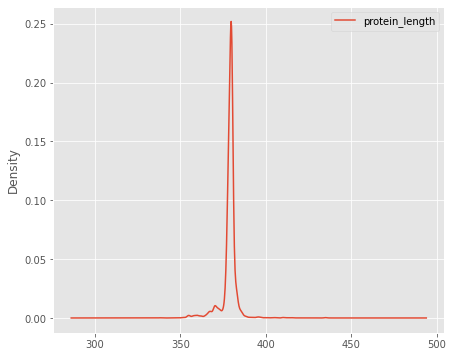

In [13]:
data_table_df.plot(kind='kde', y='protein_length', figsize=(7,6))


### Report Sequences that are too short or too long

In [17]:
#identify sequences outside of length range for analsysis
wronglength = data_table_df.loc[(data_table_df['protein_length'] < 350) | (data_table_df['protein_length'] > 390)]
wronglength

,gene_symbol,taxname,#taxid,genomic_range,orientation,location,protein_accession,protein_length,protein_name
gene_id,,,,,,,,,
807810,CYTB,Petromyzon marinus,7757,NC_001626.1:1-1191,+,chr MT,NP_008147.1,396.0,cytochrome b
808823,CYTB,Lampetra fluviatilis,7748,NC_001131.1:12150-13340,+,chr MT,NP_033650.1,396.0,cytochrome b
2960252,CYTB,Mytilus edulis,6550,NC_006161.1:2824-4017,+,chr MT,YP_073336.1,397.0,cytochrome b
3332131,CYTB,Mytilus galloprovincialis,29158,NC_006886.2:1226-2533,+,chr MT,YP_214759.2,435.0,cytochrome b
3453227,CYTB,Crassostrea virginica,6565,NC_007175.2:3647-4859,+,chr MT,YP_254651.1,403.0,cytochrome b
3562068,CYTB,Placopecten magellanicus,6577,NC_007234.1:25117-26304,+,chr MT,YP_272043.1,395.0,cytochrome b
3854369,CYTB,Mytilus trossulus,6551,NC_007687.1:4375-5682,+,chr MT,YP_448726.1,435.0,cytochrome b
5846624,CYTB,Plakinastrella cf. onkodes DVL-2011,1041945,NC_010217.1:14567-15742,+,chr MT,YP_001648681.1,391.0,cytochrome b
5846914,CYTB,Vaceletia sp. GW948,479641,NC_010218.1:6930-8105,+,chr MT,YP_001648689.1,391.0,cytochrome b


### Remove sequences that are too short or too long           

In [21]:
## filter out sequences that are either too long or too short

min_len = 349
max_len = 391

rightlength = data_table_df.loc[(data_table_df['protein_length'] > min_len) & (data_table_df['protein_length'] < max_len)]
#rightlength.to_csv("rightlength", sep='\t')
rightlength.head()
#acclist = rightlength['protein_accession']
#rightlength.to_csv('taxmap', index=False, header=False, sep ='\t', columns=['protein_accession', 'tax_id'])
#print(acclist)                           

,gene_symbol,taxname,#taxid,genomic_range,orientation,location,protein_accession,protein_length,protein_name
gene_id,,,,,,,,,
4519,CYTB,Homo sapiens,9606,NC_012920.1:14747-15887,+,chr MT,YP_003024038.1,380.0,cytochrome b
17711,CYTB,Mus musculus,10090,NC_005089.1:14145-15288,+,chr MT,NP_904340.1,381.0,cytochrome b
26192,CYTB,Rattus norvegicus,10116,NC_001665.2:14136-15278,+,chr MT,YP_665641.1,380.0,cytochrome b
140512,CYTB,Danio rerio,7955,NC_002333.2:15308-16448,+,chr MT,NP_059343.1,380.0,cytochrome b
800003,CYTB,Schistosoma mekongi,38744,NC_002529.1:2654-3772,+,chr MT,NP_065423.2,372.0,cytochrome b


In [19]:
#tooshort = data_table_df.loc[(data_table_df['protein_length'] < min_len)]  
tooshort = table_combined.loc[(table_combined['protein_length'] < min_len)] 
tooshort

,taxname,#taxid,genomic_range,protein_accession,protein_length,phylum,class,order,family,genus,species
3827,Meloidogyne incognita,6306,NC_024097.1:8728-9742,YP_009029742.1,338.0,Nematoda,Chromadorea,Rhabditida,Meloidogynidae,Meloidogyne,NaN
4621,Meloidogyne arenaria,6304,NC_026554.1:8201-9215,YP_009122960.1,338.0,Nematoda,Chromadorea,Rhabditida,Meloidogynidae,Meloidogyne,NaN
4622,Meloidogyne enterolobii,390850,NC_026555.1:8189-9209,YP_009122972.1,340.0,Nematoda,Chromadorea,Rhabditida,Meloidogynidae,Meloidogyne,NaN
4623,Meloidogyne javanica,6303,NC_026556.1:8729-9743,YP_009122984.1,338.0,Nematoda,Chromadorea,Rhabditida,Meloidogynidae,Meloidogyne,NaN
7463,Salpa thompsoni,569448,NC_037769.1:3459-4493,YP_009487037.1,344.0,Chordata,Thaliacea,Salpida,Salpidae,Salpa,NaN
7464,Salpa fusiformis,942554,NC_037770.1:3434-4468,YP_009487049.1,344.0,Chordata,Thaliacea,Salpida,Salpidae,Salpa,NaN


In [20]:
tooshort.to_csv(r'tooshort', sep ='\t', index = True)

In [23]:
toolong400 = table_combined.loc[((table_combined['phylum'] == "Cnidaria") | (table_combined['phylum'] == "Porifera")) & (table_combined['protein_length'] > 400)]
toolong415 = table_combined.loc[(table_combined['phylum'] == "Mollusca") & (table_combined['protein_length'] > 415)]
toolong390 = table_combined.loc[(table_combined['phylum'] != "Mollusca") & (table_combined['phylum'] != "Cnidaria") & (table_combined['phylum'] != "Porifera") & (table_combined['protein_length'] > max_len)]
long = [toolong400, toolong415, toolong390]
toolong = pd.concat(long)
toolong

,taxname,#taxid,genomic_range,protein_accession,protein_length,phylum,class,order,family,genus,species
566,Mytilus galloprovincialis,29158,NC_006886.2:1226-2533,YP_214759.2,435.0,Mollusca,Bivalvia,Mytiloida,Mytilidae,Mytilus,NaN
658,Mytilus trossulus,6551,NC_007687.1:4375-5682,YP_448726.1,435.0,Mollusca,Bivalvia,Mytiloida,Mytilidae,Mytilus,NaN
1857,Crassostrea iredalei,167541,NC_013997.1:3715-4965,YP_003541100.2,416.0,Mollusca,Bivalvia,Ostreida,Ostreidae,Crassostrea,NaN
2271,Mytilus californianus,6549,NC_015993.1:1176-2483,YP_004842037.1,435.0,Mollusca,Bivalvia,Mytiloida,Mytilidae,Mytilus,NaN
3134,Mactra antiquata,2302425,NC_021375.1:6599-7880,YP_008080608.1,427.0,Mollusca,Bivalvia,Venerida,Mactridae,Mactra,NaN
4074,Mytilus coruscus,42192,NC_024733.1:1182-2489,YP_009054024.1,435.0,Mollusca,Bivalvia,Mytiloida,Mytilidae,Mytilus,NaN
4156,Anadara sativa,1028096,NC_024927.1:6003-7280,YP_009059160.1,425.0,Mollusca,Bivalvia,Arcoida,Arcidae,Anadara,NaN
4253,Mactra chinensis,339787,NC_025510.1:7503-8792,YP_009104584.1,429.0,Mollusca,Bivalvia,Venerida,Mactridae,Mactra,NaN
5901,Mytilus chilensis,173667,NC_030633.1:1242-2549,YP_009268481.1,435.0,Mollusca,Bivalvia,Mytiloida,Mytilidae,Mytilus,NaN
8414,Crenomytilus grayanus,151218,NC_044128.1:9736-11043,YP_009681485.1,435.0,Mollusca,Bivalvia,Mytiloida,Mytilidae,Crenomytilus,NaN


In [24]:
toolong.to_csv(r'toolong', sep ='\t', index = True)

In [23]:
from Bio import SeqIO
sequences = [] 
for seq_record in SeqIO.parse("protein.faa", "fasta"): 
    s = seq_record    
    if seq_record.id in rightlength['protein_accession'].tolist():
        sequences.append(s)
    else:
        print("removed accessions are: ", seq_record.id)
SeqIO.write(sequences, "stripped.fsa", "fasta")  



removed accessions are:  NP_008147.1
removed accessions are:  NP_033650.1
removed accessions are:  YP_073336.1
removed accessions are:  YP_214759.2
removed accessions are:  YP_254651.1
removed accessions are:  YP_272043.1
removed accessions are:  YP_448726.1
removed accessions are:  YP_001527864.1
removed accessions are:  YP_001527851.1
removed accessions are:  YP_001648681.1
removed accessions are:  YP_001648689.1
removed accessions are:  YP_001936269.1
removed accessions are:  YP_003345455.1
removed accessions are:  YP_002860224.1
removed accessions are:  YP_002860236.1
removed accessions are:  YP_002860212.1
removed accessions are:  YP_002929379.1
removed accessions are:  YP_003162829.1
removed accessions are:  YP_003457185.1
removed accessions are:  YP_003541100.2
removed accessions are:  YP_003734676.1
removed accessions are:  YP_003934253.1
removed accessions are:  YP_003934515.1
removed accessions are:  YP_004123225.1
removed accessions are:  YP_004123265.1
removed accessions ar

10180

## Generate taxmap and save for later use

In [24]:
rightlength.to_csv('prot_taxmap', index=False, header=False, sep ='\t', columns=['protein_accession', '#taxid'])
#ADD CODE TO EXTRACT NUCLEOTIDE ACCESSIONS
#rightlength.to_csv('nuc_taxmap', index=False, header=False, sep ='\t', columns=['nucleotide_accession', '#taxid'])

## Run all-vs-all BLAST

### Small jobs run blast locally on iebdev machine

In [240]:
#!scripts/blast_all.sh -b {bdbag} -a {acclist_for_blast} -t 6
os.system("makeblastdb -in stripped.fsa -parse_seqids -dbtype prot -taxid_map prot_taxmap -out prot_blastdb")
os.system("blastp -db prot_blastdb -num_threads 6 -query stripped.fsa -outfmt '7 std qcovs staxid ssciname' -out blastout.tsv")
#os.system("blast_formatter -archive blastout.asn -outfmt '7 std staxid ssciname' -out blastout.tsv")
#os.system("blastp -db nr -num_threads 6 -query stripped.fsa -outfmt '7 std qcovs staxid ssciname' -out blastout.tsv")

0

### Big jobs run elastic blast

In [25]:
os.system("makeblastdb -in stripped.fsa -parse_seqids -dbtype prot -taxid_map prot_taxmap -out prot_blastdb")
os.system("gsutil cp prot_blastdb.p?? gs://mcveigh-test/MYDB/")
os.system("gsutil ls gs://elasticblast-mcveigh-test >& /dev/null || gsutil mb gs://elasticblast-mcveigh-test")
os.system("./submit-and-wait-for-results.sh notebook_GCP.ini 500")
os.system("gunzip -c batch_*.gz > blastout.tsv")
os.system("gsutil rm gs://mcveigh-test/results/cytb/batch'*'.gz")

256

## Read BLAST tsv file, remove matches to self
This creates a master file of the blast output with the organism names and taxids

In [26]:
file_name_string = (r'blastout.tsv')
table_df = pd.read_csv(file_name_string,
                       sep='\t',
                       index_col=None,
                       low_memory=False,
                       usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],
                       header=None,
                       names=["queryseqid", "subjectseqid", "identity", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "Evalue", "bitscore", "qcoverage", "taxid", "taxname"])
table_df = table_df[~table_df['queryseqid'].str.contains("#")]
table_df['%identity'] = pd.to_numeric(table_df['identity'])
table_df['length'] = pd.to_numeric(table_df['length'])
table_df['qstart'] = pd.to_numeric(table_df['qstart'])
table_df['qend'] = pd.to_numeric(table_df['qend'])
table_df['sstart'] = pd.to_numeric(table_df['sstart'])
table_df['send'] = pd.to_numeric(table_df['send'])
table_df['qcoverage'] = pd.to_numeric(table_df['qcoverage'])
#table_df
#strip .version if needed
#table_df['taxid'] = table_df['taxid'].astype(str)
#table_df['taxid'] = table_df['taxid'].map(lambda x: str(x)[:-2])
#table_df['queryseqid'] = table_df['queryseqid'].astype(int)
#table_df['queryseqid'] = table_df['queryseqid'].map(lambda x: int(x)[:-1])
table2_df = table_df.loc[(table_df['queryseqid']) != (table_df['subjectseqid'])]
table2_df.drop(['mismatch', 'gapopen', 'bitscore', '%identity'], axis=1, inplace=True)
table2_df

/home/mcveigh/jup/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,queryseqid,subjectseqid,identity,length,qstart,qend,sstart,send,Evalue,qcoverage,taxid,taxname
6,YP_003024038.1,YP_008963999.1,98.947,380.0,1.0,380.0,1.0,380.0,0.0,100.0,1425170.0,Homo heidelbergensis
7,YP_003024038.1,YP_003541057.1,98.421,380.0,1.0,380.0,1.0,380.0,0.0,100.0,741158.0,Homo sapiens subsp. 'Denisova'
8,YP_003024038.1,YP_002124314.2,98.158,380.0,1.0,380.0,1.0,380.0,0.0,100.0,63221.0,Homo sapiens neanderthalensis
9,YP_003024038.1,YP_003587317.1,87.599,379.0,1.0,379.0,1.0,379.0,0.0,99.0,9590.0,Symphalangus syndactylus
10,YP_003024038.1,YP_003587291.1,89.974,379.0,1.0,379.0,1.0,379.0,0.0,99.0,9589.0,Hylobates pileatus
...,...,...,...,...,...,...,...,...,...,...,...,...
5140933,YP_010133098.1,YP_009672840.1,92.084,379.0,1.0,379.0,1.0,379.0,0.0,99.0,316163.0,Nematalosa erebi
5140934,YP_010133098.1,YP_009463872.1,91.821,379.0,1.0,379.0,1.0,379.0,0.0,99.0,224703.0,Alosa aestivalis
5140935,YP_010133098.1,YP_009463859.1,91.821,379.0,1.0,379.0,1.0,379.0,0.0,99.0,469659.0,Alosa mediocris
5140936,YP_010133098.1,YP_009388858.1,90.000,380.0,1.0,380.0,1.0,380.0,0.0,100.0,322115.0,Yasuhikotakia modesta


## Create a smaller dataframe with just numberical values

In [27]:
dftidy = table2_df.drop(['taxid', 'taxname'], axis=1)
dftidy

,queryseqid,subjectseqid,identity,length,qstart,qend,sstart,send,Evalue,qcoverage
6,YP_003024038.1,YP_008963999.1,98.947,380.0,1.0,380.0,1.0,380.0,0.0,100.0
7,YP_003024038.1,YP_003541057.1,98.421,380.0,1.0,380.0,1.0,380.0,0.0,100.0
8,YP_003024038.1,YP_002124314.2,98.158,380.0,1.0,380.0,1.0,380.0,0.0,100.0
9,YP_003024038.1,YP_003587317.1,87.599,379.0,1.0,379.0,1.0,379.0,0.0,99.0
10,YP_003024038.1,YP_003587291.1,89.974,379.0,1.0,379.0,1.0,379.0,0.0,99.0
...,...,...,...,...,...,...,...,...,...,...
5140933,YP_010133098.1,YP_009672840.1,92.084,379.0,1.0,379.0,1.0,379.0,0.0,99.0
5140934,YP_010133098.1,YP_009463872.1,91.821,379.0,1.0,379.0,1.0,379.0,0.0,99.0
5140935,YP_010133098.1,YP_009463859.1,91.821,379.0,1.0,379.0,1.0,379.0,0.0,99.0
5140936,YP_010133098.1,YP_009388858.1,90.000,380.0,1.0,380.0,1.0,380.0,0.0,100.0


## Groupby and Aggregate the top ten rows of blast results

In [28]:
table3_df = dftidy.groupby('queryseqid').head(10) 
ident_group = table3_df.groupby('queryseqid').agg(['median', 'min', 'max']) 
ident_group

identity                 length               qstart            \
              median     min     max median    min    max median  min  max   
queryseqid                                                                   
NP_006901.1  96.5700  96.306  97.889  379.0  379.0  379.0    1.0  1.0  1.0   
NP_006913.1  96.4285  91.534  99.735  378.0  378.0  378.0    1.0  1.0  1.0   
NP_006940.1  96.8340  90.765  97.889  379.0  379.0  379.0    1.0  1.0  1.0   
NP_006946.1  88.7050  75.758  98.904  362.5  339.0  365.0    3.0  1.0  4.0   
NP_006958.1  95.8110  94.324  96.757  370.0  370.0  370.0    1.0  1.0  1.0   
...              ...     ...     ...    ...    ...    ...    ...  ...  ...   
YP_980164.1  79.6260  78.042  85.372  376.0  373.0  378.0    1.0  1.0  4.0   
YP_980190.1  79.6020  78.684  82.322  379.0  376.0  380.0    1.0  1.0  4.0   
YP_980203.1  80.9280  78.100  83.467  378.0  375.0  380.0    3.0  1.0  6.0   
YP_980216.1  78.2950  76.000  80.053  376.0  375.0  377.0    3.0  2.0  4.0   
YP_980229.1  83.0240  79.576  84.881  377.0  377.0  377.0    1.0  1.0  1.0   

              qend  ... sstart   send               Evalue            \
            median  ...    max median    min    max median  min  max   
queryseqid          ...                                                
NP_006901.1  379.0  ...    1.0  379.0  379.0  379.0    0.0  0.0  0.0   
NP_006913.1  378.0  ...    1.0  378.0  378.0  378.0    0.0  0.0  0.0   
NP_006940.1  379.0  ...    1.0  379.0  379.0  379.0    0.0  0.0  0.0   
NP_006946.1  365.0  ...    8.0  366.0  340.0  370.0    0.0  0.0  0.0   
NP_006958.1  370.0  ...    1.0  370.0  370.0  370.0    0.0  0.0  0.0   
...            ...  ...    ...    ...    ...    ...    ...  ...  ...   
YP_980164.1  376.0  ...    5.0  376.5  376.0  379.0    0.0  0.0  0.0   
YP_980190.1  379.0  ...    5.0  379.5  379.0  380.0    0.0  0.0  0.0   
YP_980203.1  380.0  ...    5.0  379.0  379.0  380.0    0.0  0.0  0.0   
YP_980216.1  378.0  ...    5.0  379.0  379.0  380.0    0.0  0.0  0.0   
YP_980229.1  377.0  ...    1.0  377.0  377.0  377.0    0.0  0.0  0.0   

            qcoverage                
               median    min    max  
queryseqid                           
NP_006901.1     100.0  100.0  100.0  
NP_006913.1     100.0  100.0  100.0  
NP_006940.1     100.0  100.0  100.0  
NP_006946.1      99.0   93.0  100.0  
NP_006958.1     100.0  100.0  100.0  
...               ...    ...    ...  
YP_980164.1      99.0   99.0  100.0  
YP_980190.1     100.0   99.0  100.0  
YP_980203.1      99.0   99.0  100.0  
YP_980216.1      99.0   99.0   99.0  
YP_980229.1      99.0   99.0   99.0  

[10180 rows x 24 columns]

## Convert back to one dimentional index for searborn

In [29]:
ident_group.columns = ident_group.columns.map('_'.join)
ident_group.columns.get_level_values(0)


Index(['identity_median', 'identity_min', 'identity_max', 'length_median',
       'length_min', 'length_max', 'qstart_median', 'qstart_min', 'qstart_max',
       'qend_median', 'qend_min', 'qend_max', 'sstart_median', 'sstart_min',
       'sstart_max', 'send_median', 'send_min', 'send_max', 'Evalue_median',
       'Evalue_min', 'Evalue_max', 'qcoverage_median', 'qcoverage_min',
       'qcoverage_max'],
      dtype='object')

In [30]:
ident_group

,identity_median,identity_min,identity_max,length_median,length_min,length_max,qstart_median,qstart_min,qstart_max,qend_median,...,sstart_max,send_median,send_min,send_max,Evalue_median,Evalue_min,Evalue_max,qcoverage_median,qcoverage_min,qcoverage_max
queryseqid,,,,,,,,,,,,,,,,,,,,,
NP_006901.1,96.5700,96.306,97.889,379.0,379.0,379.0,1.0,1.0,1.0,379.0,...,1.0,379.0,379.0,379.0,0.0,0.0,0.0,100.0,100.0,100.0
NP_006913.1,96.4285,91.534,99.735,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,1.0,378.0,378.0,378.0,0.0,0.0,0.0,100.0,100.0,100.0
NP_006940.1,96.8340,90.765,97.889,379.0,379.0,379.0,1.0,1.0,1.0,379.0,...,1.0,379.0,379.0,379.0,0.0,0.0,0.0,100.0,100.0,100.0
NP_006946.1,88.7050,75.758,98.904,362.5,339.0,365.0,3.0,1.0,4.0,365.0,...,8.0,366.0,340.0,370.0,0.0,0.0,0.0,99.0,93.0,100.0
NP_006958.1,95.8110,94.324,96.757,370.0,370.0,370.0,1.0,1.0,1.0,370.0,...,1.0,370.0,370.0,370.0,0.0,0.0,0.0,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YP_980164.1,79.6260,78.042,85.372,376.0,373.0,378.0,1.0,1.0,4.0,376.0,...,5.0,376.5,376.0,379.0,0.0,0.0,0.0,99.0,99.0,100.0
YP_980190.1,79.6020,78.684,82.322,379.0,376.0,380.0,1.0,1.0,4.0,379.0,...,5.0,379.5,379.0,380.0,0.0,0.0,0.0,100.0,99.0,100.0
YP_980203.1,80.9280,78.100,83.467,378.0,375.0,380.0,3.0,1.0,6.0,380.0,...,5.0,379.0,379.0,380.0,0.0,0.0,0.0,99.0,99.0,100.0


In [31]:
ident_group.to_csv(r'ident_group_file', sep ='\t', index = True)

## Let's plot the query coverage data to visual

<AxesSubplot:ylabel='Density'>

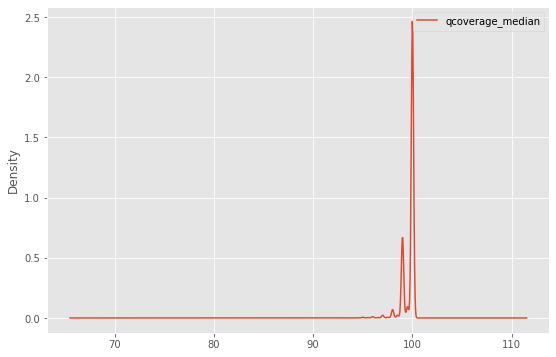

In [32]:
ident_group.plot(kind='kde', y='qcoverage_median', figsize=(9,6))
#ident_group.savefig('qcov_median.png')

## Median %identity

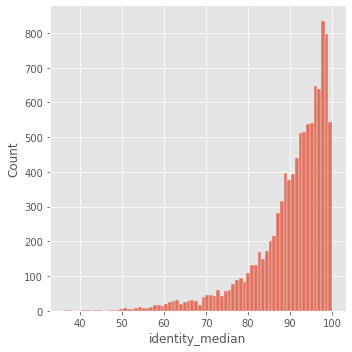

<Figure size 432x288 with 0 Axes>

In [33]:
sns.displot(ident_group.identity_median.dropna())
plt.show()
plt.savefig('identity_displot.png')

## Identify sequences with values below the pass/fail thresholds %identity and query coverage

### Determine taxonomic relationships of the organisms in the top ten BLAST returns per query

In [34]:
table5_df = table_df.groupby('queryseqid')['queryseqid', 'subjectseqid', 'taxname'].head(11)
#table5_df.drop_duplicates(subset=['taxname'], inplace=True)
#table5_df['taxid'] = table5_df['taxid'].astype(int)
table5_df.to_csv(r'table5_df', sep ='\t', index = True)
table5_df

<ipython-input-34-1288fdd5ddb8>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  table5_df = table_df.groupby('queryseqid')['queryseqid', 'subjectseqid', 'taxname'].head(11)


,queryseqid,subjectseqid,taxname
5,YP_003024038.1,YP_003024038.1,Homo sapiens
6,YP_003024038.1,YP_008963999.1,Homo heidelbergensis
7,YP_003024038.1,YP_003541057.1,Homo sapiens subsp. 'Denisova'
8,YP_003024038.1,YP_002124314.2,Homo sapiens neanderthalensis
9,YP_003024038.1,YP_003587317.1,Symphalangus syndactylus
...,...,...,...
5140444,YP_010133098.1,YP_010133033.1,Percina macrocephala
5140445,YP_010133098.1,YP_009429073.1,Etheostoma chuckwachatte
5140446,YP_010133098.1,YP_009429099.1,Percina crypta
5140447,YP_010133098.1,YP_009427741.1,Etheostoma tallapoosae


In [35]:
table8_df = pd.merge(left=table5_df, right=lineage_df, left_on='taxname', right_on='taxname', how='left')
table8_df.to_csv(r'table8_df', sep ='\t', index = True)
table8_df

,queryseqid,subjectseqid,taxname,#taxid,phylum,class,order,family,genus,species
0,YP_003024038.1,YP_003024038.1,Homo sapiens,9606,Chordata,Mammalia,Primates,Hominidae,Homo,NaN
1,YP_003024038.1,YP_008963999.1,Homo heidelbergensis,1425170,Chordata,Mammalia,Primates,Hominidae,Homo,NaN
2,YP_003024038.1,YP_003541057.1,Homo sapiens subsp. 'Denisova',741158,Chordata,Mammalia,Primates,Hominidae,Homo,Homo sapiens
3,YP_003024038.1,YP_002124314.2,Homo sapiens neanderthalensis,63221,Chordata,Mammalia,Primates,Hominidae,Homo,Homo sapiens
4,YP_003024038.1,YP_003587317.1,Symphalangus syndactylus,9590,Chordata,Mammalia,Primates,Hylobatidae,Symphalangus,NaN
...,...,...,...,...,...,...,...,...,...,...
112071,YP_010133098.1,YP_010133033.1,Percina macrocephala,163821,Chordata,Actinopteri,Perciformes,Percidae,Percina,NaN
112072,YP_010133098.1,YP_009429073.1,Etheostoma chuckwachatte,310366,Chordata,Actinopteri,Perciformes,Percidae,Etheostoma,NaN
112073,YP_010133098.1,YP_009429099.1,Percina crypta,1070206,Chordata,Actinopteri,Perciformes,Percidae,Percina,NaN
112074,YP_010133098.1,YP_009427741.1,Etheostoma tallapoosae,162989,Chordata,Actinopteri,Perciformes,Percidae,Etheostoma,NaN


In [36]:
group_lineage = table8_df.groupby('queryseqid')
common_rank = []
for name, group in group_lineage:  
    uniques = []
    taxvalue = []
    uniques = group['genus'].nunique(dropna=True)
    if uniques == 1:
        #print(name, group['genus'])
        taxvalue = name, group['genus']
        #print(taxvalue)
        common_rank.append(taxvalue)
    elif uniques > 1:
        uniques = group['family'].nunique(dropna=True)
        if uniques == 1:
            taxvalue = name, group['family']
            #print(taxvalue)
            common_rank.append(taxvalue)
        elif uniques > 1:
            uniques = group['order'].nunique(dropna=True)
            if uniques == 1:
                taxvalue = name, group['order']
                #print(taxvalue)
                common_rank.append(taxvalue)
            elif uniques > 1:
                uniques = group['class'].nunique(dropna=True) 
                if uniques == 1:
                    taxvalue = name, group['class']
                    #print(taxvalue)
                    common_rank.append(taxvalue)
                elif uniques > 1:
                    uniques = group['phylum'].nunique(dropna=True) 
                    if uniques == 1:
                        taxvalue = name, group['phylum']
                        #print(taxvalue)
                        common_rank.append(taxvalue)
#print(common_rank) 

In [37]:
f = open('commonranks', 'w')
for t in common_rank:
    line = ' '.join(str(x) for x in t)
    f.write(line + '\n')
f.close()

In [209]:
#align_percent['taxa'] = align_percent['taxa'].str.strip()
#align_percent

In [175]:
#align_data = pd.read_csv("align_percent_summary", sep='\t', index_col=None)
#align_data.drop(columns=['Unnamed: 0'], inplace=True)

#align_data.dtypes


description    object
value          object
taxa           object
dtype: object

In [38]:
commonrank = pd.DataFrame(common_rank, columns = ['queryseqid', 'taxa']) 
commonrank['taxa'] = commonrank['taxa'].astype(str)
commonrank['taxa'] = commonrank['taxa'].str.replace('\d+', '')
commonrank['taxa'] = commonrank['taxa'].str.replace('\n', ' ')
commonrank['taxa'] = commonrank['taxa'].str.replace('NaN', '')
commonrank['taxa'] = commonrank['taxa'].str.replace(r'\b(\w+)(\s+\1)+\b', r'\1')
commonrank['taxa'] = commonrank['taxa'].str.split('Name').str[0]
#commonrank['taxa'] = commonrank['taxa'].astype(object)
commonrank['taxa'] = commonrank['taxa'].str.strip()
commonrank.head(100)


<ipython-input-38-a82881aff906>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  commonrank['taxa'] = commonrank['taxa'].str.replace('\d+', '')
<ipython-input-38-a82881aff906>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  commonrank['taxa'] = commonrank['taxa'].str.replace(r'\b(\w+)(\s+\1)+\b', r'\1')


,queryseqid,taxa
0,NP_006901.1,Artiodactyla
1,NP_006913.1,Diptera
2,NP_006940.1,Carnivora
3,NP_006946.1,Chromadorea
4,NP_006958.1,Caenorhabditis
5,NP_006977.1,Echinoidea
6,NP_007068.1,Artiodactyla
7,NP_007081.1,Phocidae
8,NP_007094.1,Cyprinidae
9,NP_007107.1,Mammalia


In [39]:
rankidentity = pd.merge(left=commonrank, right=align_percent, on='taxa')
rankidentity.to_csv(r'rankidentity', sep ='\t', index = True) 
rankidentity['value'] = rankidentity['value'].str.replace('%', '')
rankidentity

,queryseqid,taxa,description,value
0,NP_006901.1,Artiodactyla,Average identity,91
1,NP_007068.1,Artiodactyla,Average identity,91
2,NP_062479.1,Artiodactyla,Average identity,91
3,NP_944619.1,Artiodactyla,Average identity,91
4,NP_944632.1,Artiodactyla,Average identity,91
...,...,...,...,...
10001,YP_010031513.1,Noctuidae,Average identity,93
10002,YP_010037169.1,Herpestidae,Average identity,96
10003,YP_010129813.1,Trachypithecus,Average identity,95
10004,YP_214952.1,Trachypithecus,Average identity,95


In [40]:
masterident = pd.merge(left=ident_group, right=rankidentity, left_on='queryseqid', right_on='queryseqid', how='left')
masterident.to_csv(r'masterident', sep ='\t', index = True) 
masterident['identity_median'] = pd.to_numeric(masterident['identity_median'])
masterident['value'] = pd.to_numeric(masterident['value'])
#masterident['value'] = masterident['value'].astype(int)
masterident.set_index(['queryseqid'], inplace = True)
masterident

,identity_median,identity_min,identity_max,length_median,length_min,length_max,qstart_median,qstart_min,qstart_max,qend_median,...,send_max,Evalue_median,Evalue_min,Evalue_max,qcoverage_median,qcoverage_min,qcoverage_max,taxa,description,value
queryseqid,,,,,,,,,,,,,,,,,,,,,
NP_006901.1,96.5700,96.306,97.889,379.0,379.0,379.0,1.0,1.0,1.0,379.0,...,379.0,0.0,0.0,0.0,100.0,100.0,100.0,Artiodactyla,Average identity,91.0
NP_006913.1,96.4285,91.534,99.735,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,378.0,0.0,0.0,0.0,100.0,100.0,100.0,Diptera,Average identity,83.0
NP_006940.1,96.8340,90.765,97.889,379.0,379.0,379.0,1.0,1.0,1.0,379.0,...,379.0,0.0,0.0,0.0,100.0,100.0,100.0,Carnivora,Average identity,91.0
NP_006946.1,88.7050,75.758,98.904,362.5,339.0,365.0,3.0,1.0,4.0,365.0,...,370.0,0.0,0.0,0.0,99.0,93.0,100.0,Chromadorea,Average identity,65.0
NP_006958.1,95.8110,94.324,96.757,370.0,370.0,370.0,1.0,1.0,1.0,370.0,...,370.0,0.0,0.0,0.0,100.0,100.0,100.0,Caenorhabditis,Average identity,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YP_980164.1,79.6260,78.042,85.372,376.0,373.0,378.0,1.0,1.0,4.0,376.0,...,379.0,0.0,0.0,0.0,99.0,99.0,100.0,Chordata,Average identity,76.0
YP_980190.1,79.6020,78.684,82.322,379.0,376.0,380.0,1.0,1.0,4.0,379.0,...,380.0,0.0,0.0,0.0,100.0,99.0,100.0,Chordata,Average identity,76.0
YP_980203.1,80.9280,78.100,83.467,378.0,375.0,380.0,3.0,1.0,6.0,380.0,...,380.0,0.0,0.0,0.0,99.0,99.0,100.0,Chordata,Average identity,76.0


In [41]:
#master_full_output = pd.merge(left=masterident, right=table_combined, left_on='queryseqid', right_on='protein_accession', how='left')
master_full_output = pd.merge(left=table_combined, right=masterident, left_on='protein_accession', right_on='queryseqid', how='left')
master_full_output.to_csv(r'master_full_output', sep ='\t', index = True) 
master_full_output

,taxname,#taxid,genomic_range,protein_accession,protein_length,phylum,class,order,family,genus,...,send_max,Evalue_median,Evalue_min,Evalue_max,qcoverage_median,qcoverage_min,qcoverage_max,taxa,description,value
0,Homo sapiens,9606,NC_012920.1:14747-15887,YP_003024038.1,380.0,Chordata,Mammalia,Primates,Hominidae,Homo,...,380.0,0.000000e+00,0.0,0.000000e+00,99.5,99.0,100.0,Mammalia,Average identity,83.0
1,Mus musculus,10090,NC_005089.1:14145-15288,NP_904340.1,381.0,Chordata,Mammalia,Rodentia,Muridae,Mus,...,381.0,0.000000e+00,0.0,0.000000e+00,100.0,100.0,100.0,Mus,Average identity,97.0
2,Rattus norvegicus,10116,NC_001665.2:14136-15278,YP_665641.1,380.0,Chordata,Mammalia,Rodentia,Muridae,Rattus,...,380.0,0.000000e+00,0.0,0.000000e+00,100.0,100.0,100.0,Muridae,Average identity,92.0
3,Danio rerio,7955,NC_002333.2:15308-16448,NP_059343.1,380.0,Chordata,Actinopteri,Cypriniformes,Danionidae,Danio,...,380.0,0.000000e+00,0.0,0.000000e+00,100.0,99.0,100.0,Cypriniformes,Average identity,93.0
4,Schistosoma mekongi,38744,NC_002529.1:2654-3772,NP_065423.2,372.0,Platyhelminthes,Trematoda,Strigeidida,Schistosomatidae,Schistosoma,...,367.0,8.419000e-150,0.0,1.700000e-147,97.0,95.0,99.0,Platyhelminthes,Average identity,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10277,Percina copelandi,54323,NC_056401.1:14380-15520,YP_010133046.1,380.0,Chordata,Actinopteri,Perciformes,Percidae,Percina,...,380.0,0.000000e+00,0.0,0.000000e+00,100.0,99.0,100.0,Percidae,Average identity,97.0
10278,Proterorhinus semilunaris,322563,NC_056402.1:14427-15564,YP_010133059.1,379.0,Chordata,Actinopteri,Gobiiformes,Gobiidae,Proterorhinus,...,379.0,0.000000e+00,0.0,0.000000e+00,99.0,99.0,100.0,Gobiidae,Average identity,92.0
10279,Ophichthys cuchia,2793285,NC_056403.1:14331-15468,YP_010133072.1,379.0,Chordata,Actinopteri,Synbranchiformes,Synbranchidae,Ophichthys,...,381.0,0.000000e+00,0.0,0.000000e+00,99.5,99.0,100.0,Actinopteri,Average identity,87.0
10280,Carpiodes cyprinus,244777,NC_056404.1:14399-15539,YP_010133085.1,380.0,Chordata,Actinopteri,Cypriniformes,Catostomidae,Carpiodes,...,380.0,0.000000e+00,0.0,0.000000e+00,100.0,100.0,100.0,Catostomidae,Average identity,98.0


### Passing sequences

In [42]:
masterpass_df = masterident.loc[(masterident['identity_max'] > masterident['value']) & (masterident['qcoverage_median'] > 92)]
masterpass_df.to_csv(r'masterpass_df', sep ='\t', index = True) 
masterpass_df

,identity_median,identity_min,identity_max,length_median,length_min,length_max,qstart_median,qstart_min,qstart_max,qend_median,...,send_max,Evalue_median,Evalue_min,Evalue_max,qcoverage_median,qcoverage_min,qcoverage_max,taxa,description,value
queryseqid,,,,,,,,,,,,,,,,,,,,,
NP_006901.1,96.5700,96.306,97.889,379.0,379.0,379.0,1.0,1.0,1.0,379.0,...,379.0,0.0,0.0,0.0,100.0,100.0,100.0,Artiodactyla,Average identity,91.0
NP_006913.1,96.4285,91.534,99.735,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,378.0,0.0,0.0,0.0,100.0,100.0,100.0,Diptera,Average identity,83.0
NP_006940.1,96.8340,90.765,97.889,379.0,379.0,379.0,1.0,1.0,1.0,379.0,...,379.0,0.0,0.0,0.0,100.0,100.0,100.0,Carnivora,Average identity,91.0
NP_006946.1,88.7050,75.758,98.904,362.5,339.0,365.0,3.0,1.0,4.0,365.0,...,370.0,0.0,0.0,0.0,99.0,93.0,100.0,Chromadorea,Average identity,65.0
NP_006958.1,95.8110,94.324,96.757,370.0,370.0,370.0,1.0,1.0,1.0,370.0,...,370.0,0.0,0.0,0.0,100.0,100.0,100.0,Caenorhabditis,Average identity,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YP_973152.1,89.2855,88.889,96.032,378.0,378.0,378.0,1.0,1.0,1.0,378.0,...,378.0,0.0,0.0,0.0,100.0,100.0,100.0,Diptera,Average identity,83.0
YP_980164.1,79.6260,78.042,85.372,376.0,373.0,378.0,1.0,1.0,4.0,376.0,...,379.0,0.0,0.0,0.0,99.0,99.0,100.0,Chordata,Average identity,76.0
YP_980190.1,79.6020,78.684,82.322,379.0,376.0,380.0,1.0,1.0,4.0,379.0,...,380.0,0.0,0.0,0.0,100.0,99.0,100.0,Chordata,Average identity,76.0


### Lookup the expected %identity of the specific tax group for each query and use this to populate identity_max number for the pass/fail selection

In [43]:
identity_low = masterident.loc[(masterident['identity_max'] < masterident['value'])].index.tolist()
#len(identity_low)
identity_low

['NP_007354.1',
 'NP_007561.1',
 'NP_007626.1',
 'NP_008243.1',
 'NP_062479.1',
 'NP_067147.1',
 'NP_075407.1',
 'NP_075459.1',
 'NP_110516.1',
 'NP_443657.1',
 'NP_542468.1',
 'NP_542476.1',
 'NP_612818.1',
 'NP_659349.1',
 'NP_659375.1',
 'NP_739645.1',
 'NP_739697.1',
 'NP_739944.1',
 'NP_739957.1',
 'NP_740009.1',
 'NP_740191.1',
 'NP_758884.1',
 'NP_818799.1',
 'NP_839823.1',
 'NP_943616.1',
 'NP_944723.1',
 'NP_991052.1',
 'YP_001260498.1',
 'YP_001315148.1',
 'YP_001382317.1',
 'YP_001648661.1',
 'YP_001650798.1',
 'YP_001837107.1',
 'YP_001936591.1',
 'YP_001974707.1',
 'YP_001994352.1',
 'YP_001994417.1',
 'YP_002317256.1',
 'YP_002317378.1',
 'YP_002317393.1',
 'YP_002333205.1',
 'YP_002333231.1',
 'YP_002727966.1',
 'YP_002735121.1',
 'YP_002887519.1',
 'YP_002889407.1',
 'YP_002907411.1',
 'YP_002971045.1',
 'YP_003097124.1',
 'YP_003204693.1',
 'YP_003204779.1',
 'YP_003227104.1',
 'YP_003288848.1',
 'YP_003331314.1',
 'YP_003345071.1',
 'YP_003345175.1',
 'YP_003345214.1'

In [45]:
identity_low_df = master_full_output[(master_full_output['identity_max'] < master_full_output['value'])]
identity_low_df.to_csv(r'identity_low_df', sep ='\t', index = True) 
identity_low_df

,taxname,#taxid,genomic_range,protein_accession,protein_length,phylum,class,order,family,genus,...,send_max,Evalue_median,Evalue_min,Evalue_max,qcoverage_median,qcoverage_min,qcoverage_max,taxa,description,value
9,Sigmops gracilis,48457,NC_002574.1:14614-15762,NP_067147.1,382.0,Chordata,Actinopteri,Stomiiformes,Gonostomatidae,Sigmops,...,382.0,0.000000e+00,0.000000e+00,0.000000e+00,99.0,99.0,99.0,Actinopteri,Average identity,87.0
21,Thryonomys swinderianus,10169,NC_002658.1:14403-15540,NP_075407.1,379.0,Chordata,Mammalia,Rodentia,Thryonomyidae,Thryonomys,...,379.0,0.000000e+00,0.000000e+00,0.000000e+00,100.0,99.0,100.0,Rodentia,Average identity,86.0
22,Cochliomyia hominivorax,115425,NC_002660.1:11607-12743,NP_075459.1,378.0,Arthropoda,Insecta,Diptera,Calliphoridae,Cochliomyia,...,378.0,0.000000e+00,0.000000e+00,0.000000e+00,100.0,100.0,100.0,Calliphoridae,Average identity,98.0
28,Anguilla japonica,7937,NC_002707.2:14430-15569,NP_110516.1,379.0,Chordata,Actinopteri,Anguilliformes,Anguillidae,Anguilla,...,379.0,0.000000e+00,0.000000e+00,0.000000e+00,100.0,100.0,100.0,Anguilla,Average identity,99.0
69,Monopterus albus,43700,NC_003192.1:14339-15476,NP_443657.1,379.0,Chordata,Actinopteri,Synbranchiformes,Synbranchidae,Monopterus,...,380.0,0.000000e+00,0.000000e+00,0.000000e+00,99.0,99.0,99.0,Actinopteri,Average identity,87.0
108,Lepidosiren paradoxa,7883,NC_003342.1:14140-15279,NP_542468.1,379.0,Chordata,NaN,Ceratodontiformes,Lepidosirenidae,Lepidosiren,...,378.0,0.000000e+00,0.000000e+00,0.000000e+00,99.0,99.0,99.0,Actinopteri,Average identity,87.0
110,Narceus annularus,174156,NC_003343.1:5102-6220,NP_542476.1,372.0,Arthropoda,Diplopoda,Spirobolida,Spirobolidae,Narceus,...,372.0,0.000000e+00,0.000000e+00,0.000000e+00,99.5,97.0,100.0,Arthropoda,Average identity,68.0
120,Acropora tenuis,70783,NC_003522.1:4570-5724,NP_612818.1,384.0,Cnidaria,Anthozoa,Scleractinia,Acroporidae,Acropora,...,385.0,0.000000e+00,0.000000e+00,0.000000e+00,100.0,100.0,100.0,Acropora,Average identity,99.0
125,Galeopterus variegatus,482537,NC_004031.1:14151-15290,NP_659375.1,379.0,Chordata,Mammalia,Dermoptera,Cynocephalidae,Galeopterus,...,379.0,0.000000e+00,0.000000e+00,0.000000e+00,100.0,100.0,100.0,Mammalia,Average identity,83.0
130,Odobenus rosmarus rosmarus,62698,NC_004029.2:14173-15312,NP_659349.1,379.0,Chordata,Mammalia,Carnivora,Odobenidae,Odobenus,...,379.0,0.000000e+00,0.000000e+00,0.000000e+00,100.0,100.0,100.0,Carnivora,Average identity,91.0


In [46]:
qcov_low = ident_group[ident_group['qcoverage_median'] < 93].index.tolist()
qcov_low 

['YP_001054740.1',
 'YP_004891181.1',
 'YP_005351101.1',
 'YP_009169837.1',
 'YP_009726868.1',
 'YP_492558.1']

In [47]:
qcov_low_df = master_full_output[master_full_output['qcoverage_median'] < 93]
qcov_low_df.to_csv(r'qcov_low_df', sep ='\t', index = True) 
qcov_low_df


,taxname,#taxid,genomic_range,protein_accession,protein_length,phylum,class,order,family,genus,...,send_max,Evalue_median,Evalue_min,Evalue_max,qcoverage_median,qcoverage_min,qcoverage_max,taxa,description,value
678,Lottia digitalis,225159,NC_007782.1:14051-15220,YP_492558.1,389.0,Mollusca,Gastropoda,NaN,Lottiidae,Lottia,...,376.0,5.525000e-146,1.780000e-147,8.010000e-146,91.5,89.0,95.0,NaN,NaN,NaN
935,Microcotyle sebastis,116890,NC_009055.1:1623-2783,YP_001054740.1,386.0,Platyhelminthes,Monogenea,Mazocraeidea,Microcotylidae,Microcotyle,...,386.0,3.585000e-88,0.000000e+00,1.630000e-84,91.0,89.0,99.0,Platyhelminthes,Average identity,56.0
2279,Polylabris halichoeres,1004784,NC_016057.1:5333-6505,YP_004891181.1,390.0,Platyhelminthes,Monogenea,Mazocraeidea,Microcotylidae,Polylabris,...,385.0,4.730000e-88,0.000000e+00,1.870000e-86,90.0,87.0,99.0,Platyhelminthes,Average identity,56.0
2403,Pseudochauhanea macrorchis,1086615,NC_016950.1:4766-5926,YP_005351101.1,386.0,Platyhelminthes,Monogenea,Mazocraeidea,Chauhaneidae,Pseudochauhanea,...,383.0,6.095000e-85,0.000000e+00,2.860000e-84,89.5,88.0,98.0,Platyhelminthes,Average identity,56.0
5053,Echinostoma hortense,48216,NC_028010.1:718-1791,YP_009169837.1,357.0,Platyhelminthes,Trematoda,Plagiorchiida,Echinostomatidae,Echinostoma,...,333.0,3.160000e-148,1.130000e-151,1.650000e-144,77.0,77.0,92.0,Trematoda,Average identity,67.0
8808,Hormiphora californensis,1403702,NC_045864.1:8541-9644,YP_009726868.1,367.0,Ctenophora,Tentaculata,Cydippida,Pleurobrachiidae,Hormiphora,...,367.0,1.047500e-57,6.800000e-109,1.420000e-56,89.0,86.0,93.0,NaN,NaN,NaN


Test start and end analysis

In [48]:
#start_mismatch = masterident.loc[(masterident['qstart_min'] != masterident['sstart_min'])] 
start_mismatch = masterident.loc[(masterident['qstart_min'] > 6)] 
start_mismatch

,identity_median,identity_min,identity_max,length_median,length_min,length_max,qstart_median,qstart_min,qstart_max,qend_median,...,send_max,Evalue_median,Evalue_min,Evalue_max,qcoverage_median,qcoverage_min,qcoverage_max,taxa,description,value
queryseqid,,,,,,,,,,,,,,,,,,,,,
YP_003354969.1,61.1630,60.477,83.289,377.0,377.0,381.0,8.0,7.0,9.0,384.0,...,384.0,1.285000e-175,0.000000e+00,3.580000e-174,97.0,97.0,98.0,Unionida,Average identity,80.0
YP_003934244.1,56.2975,55.263,61.389,376.0,360.0,383.0,10.0,7.0,12.0,383.0,...,368.0,2.660000e-145,1.900000e-149,2.580000e-144,97.0,93.0,98.0,NaN,NaN,NaN
YP_004300306.1,72.0865,45.405,77.600,362.0,350.0,376.0,23.0,7.0,37.0,384.0,...,381.0,0.000000e+00,0.000000e+00,4.240000e-116,94.0,91.0,97.0,Bivalvia,Average identity,55.0
YP_007183134.1,50.5680,46.648,62.040,352.5,346.0,358.0,11.0,8.0,17.0,362.0,...,362.0,1.650011e-114,5.890000e-151,5.120000e-113,95.0,93.0,95.0,NaN,NaN,NaN
YP_008081085.1,91.7665,89.034,97.911,383.0,382.0,383.0,7.0,7.0,8.0,389.0,...,383.0,0.000000e+00,0.000000e+00,0.000000e+00,98.0,98.0,98.0,Lepidoptera,Average identity,85.0
YP_009020947.2,53.9510,53.134,59.599,367.0,349.0,367.0,15.0,9.0,22.0,373.0,...,368.0,5.230000e-145,8.580000e-148,2.290000e-144,96.0,93.0,98.0,Insecta,Average identity,71.0
YP_009186376.1,66.8550,65.352,75.775,354.0,345.0,355.0,7.0,7.0,7.0,360.0,...,370.0,1.505000e-167,4.410000e-178,3.730000e-167,98.0,96.0,98.0,Chromadorea,Average identity,65.0
YP_009328202.1,72.1755,67.297,99.451,361.5,356.0,370.0,11.0,8.0,18.0,372.0,...,370.0,0.000000e+00,0.000000e+00,0.000000e+00,96.0,94.0,97.0,Stylommatophora,Average identity,64.0
YP_009391116.1,54.2250,51.437,56.410,351.0,347.0,356.0,12.0,12.0,13.0,361.0,...,366.0,3.485000e-124,3.700000e-126,7.500000e-123,96.0,95.0,97.0,NaN,NaN,NaN


In [49]:
stop_mismatch = masterident.loc[(masterident['qend_max'] != masterident['send_max'])] 
stop_mismatch

,identity_median,identity_min,identity_max,length_median,length_min,length_max,qstart_median,qstart_min,qstart_max,qend_median,...,send_max,Evalue_median,Evalue_min,Evalue_max,qcoverage_median,qcoverage_min,qcoverage_max,taxa,description,value
queryseqid,,,,,,,,,,,,,,,,,,,,,
NP_006946.1,88.7050,75.758,98.904,362.5,339.0,365.0,3.0,1.0,4.0,365.0,...,370.0,0.000000e+00,0.000000e+00,0.000000e+00,99.0,93.0,100.0,Chromadorea,Average identity,65.0
NP_007119.1,77.2610,72.872,92.819,376.0,376.0,376.0,6.0,6.0,6.0,381.0,...,377.0,0.000000e+00,0.000000e+00,0.000000e+00,99.0,99.0,99.0,Branchiopoda,Average identity,76.0
NP_007332.1,70.7870,68.539,73.011,353.0,349.0,363.0,3.0,1.0,3.0,354.0,...,370.0,0.000000e+00,0.000000e+00,0.000000e+00,96.0,95.0,99.0,Gastropoda,Average identity,68.0
NP_008146.1,95.0000,94.737,96.579,380.0,380.0,380.0,1.0,1.0,1.0,379.0,...,380.0,0.000000e+00,0.000000e+00,0.000000e+00,100.0,100.0,100.0,Xenopus,Average identity,96.0
NP_008360.2,68.0755,63.661,73.464,358.5,342.0,366.0,8.5,5.0,22.0,365.0,...,367.0,3.860000e-169,0.000000e+00,6.100000e-166,95.5,91.0,97.0,Stylommatophora,Average identity,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YP_918965.1,54.6035,44.350,75.000,351.0,334.0,360.0,8.0,4.0,16.0,352.0,...,372.0,7.850000e-119,0.000000e+00,1.760000e-101,95.0,91.0,99.0,NaN,NaN,NaN
YP_918978.1,54.2480,46.779,68.876,352.5,341.0,359.0,3.0,1.0,11.0,348.0,...,374.0,2.169200e-117,8.920000e-170,2.660000e-101,98.0,95.0,99.0,NaN,NaN,NaN
YP_980164.1,79.6260,78.042,85.372,376.0,373.0,378.0,1.0,1.0,4.0,376.0,...,379.0,0.000000e+00,0.000000e+00,0.000000e+00,99.0,99.0,100.0,Chordata,Average identity,76.0


## Sort fasta file creating two files [1] seqs that pass [2] seqs that fail

In [50]:
from Bio import SeqIO
sequences = [] 
fail_sequence = []
for seq_record in SeqIO.parse("stripped.fsa", "fasta"):
    s = seq_record
    if seq_record.id in identity_low:
        print("fails seq identity test", seq_record.id)
        fail_sequence.append(s)
    elif seq_record.id in qcov_low:
        fail_sequence.append(s)
        print("fails qcov test",seq_record.id)
    else:
        sequences.append(s)
        #print(seq_record.id)
        
SeqIO.write(sequences, "outputfile", "fasta")

fails seq identity test NP_067147.1
fails seq identity test NP_075407.1
fails seq identity test NP_075459.1
fails seq identity test NP_110516.1
fails seq identity test NP_443657.1
fails seq identity test NP_542468.1
fails seq identity test NP_542476.1
fails seq identity test NP_612818.1
fails seq identity test NP_659375.1
fails seq identity test NP_659349.1
fails seq identity test NP_740191.1
fails seq identity test NP_739645.1
fails seq identity test NP_739697.1
fails seq identity test NP_739944.1
fails seq identity test NP_739957.1
fails seq identity test NP_740009.1
fails seq identity test NP_758884.1
fails seq identity test NP_818799.1
fails seq identity test NP_839823.1
fails seq identity test NP_008243.1
fails seq identity test NP_007354.1
fails seq identity test NP_007561.1
fails seq identity test NP_007626.1
fails seq identity test NP_062479.1
fails seq identity test NP_943616.1
fails seq identity test NP_944723.1
fails seq identity test NP_991052.1
fails seq identity test YP_0

fails seq identity test YP_009487409.1
fails seq identity test YP_009487743.1
fails seq identity test YP_009487847.1
fails seq identity test YP_009488029.1
fails seq identity test YP_009503284.1
fails seq identity test YP_009510326.1
fails seq identity test YP_009512897.1
fails seq identity test YP_009519719.1
fails seq identity test YP_009519785.1
fails seq identity test YP_009526498.1
fails seq identity test YP_009526513.1
fails seq identity test YP_009540822.1
fails seq identity test YP_009542029.1
fails seq identity test YP_009544458.1
fails seq identity test YP_009544446.1
fails seq identity test YP_009558636.1
fails seq identity test YP_009560258.1
fails seq identity test YP_009630251.1
fails seq identity test YP_009630778.1
fails seq identity test YP_009647955.1
fails seq identity test YP_009652908.1
fails seq identity test YP_009660726.1
fails seq identity test YP_009668621.1
fails seq identity test YP_009671879.1
fails seq identity test YP_009673462.1
fails seq identity test Y

9764

In [51]:
sh = open("protein.faa")
num = 0
for line in sh:
    if line.startswith(">"):
        num += 1
sh.close()
print("Number of sequences in the starting input file:", num)

Number of sequences in the starting input file: 10284


In [52]:
fh = open("outputfile")
n = 0
for line in fh:
    if line.startswith(">"):
        n += 1
fh.close()
print("Number of sequences passing all validation tests and saved to outputfile:", n)

Number of sequences passing all validation tests and saved to outputfile: 9764
